# From cosmology to linear power parameters
We would like to see if we can compress the linear power spectrum information in a handful of parameters.

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.dpi'] = 150
import camb
from camb import model, initialpower
import fit_pk
import read_genic

### Specify cosmological models

In [2]:
# read cosmology from GenIC file
cosmo_genic = 'param_keir.genic'
#cosmo_genic = 'param_chris.genic'
cosmo_dict = read_genic.camb_from_genic(cosmo_genic)
#print(cosmo_dict)
pars = fit_pk.get_cosmology(cosmo_dict)

In [3]:
# setup fiducial cosmology
pars_fid = fit_pk.get_cosmology(mnu=0.3)

### Compute ratio of power at $z_\star=3$ and fit a polynomial to log ratio

In [4]:
z_star=3.0
kmin_kms=0.001
kmax_kms=0.05
linP_ratio_kms = fit_pk.fit_linP_ratio_kms(pars,pars_fid,z_star,kmin_kms,kmax_kms,deg=2)

### Compute logarithmic growth rate for both cosmologies

In [5]:
f_star = fit_pk.fit_f_star(pars,z_star)
f_star_fid = fit_pk.fit_f_star(pars_fid,z_star)
print('f_star =',f_star)
print('f_star_fid =',f_star_fid)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
f_star = 0.973181328916
f_star_fid = 0.968830468706


### Compute derivative of Hubble parameter, with respect to EdS

In [6]:
g_star = fit_pk.fit_g_star(pars,z_star)
g_star_fid = fit_pk.fit_g_star(pars_fid,z_star)
print('g_star =',g_star)
print('g_star_fid =',g_star_fid)

g_star = -0.017499223223382935
g_star_fid = -0.011733443743696377


### Reconstruct the linear power using the shape parameters and the logarithmic growth rate

In [7]:
# compute first linear power spectra, in velocity units
# output redshifts
zs=[2,3,4,5]
Nz=len(zs)
k_kms, zs_out, P_kms = fit_pk.get_Plin_kms(pars,zs)
k_kms_fid, _, P_kms_fid = fit_pk.get_Plin_kms(pars_fid,zs)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [8]:
results = camb.get_results(pars)
H_star = results.hubble_parameter(z=z_star)
results_fid = camb.get_results(pars_fid)
H_star_fid = results_fid.hubble_parameter(z=z_star)

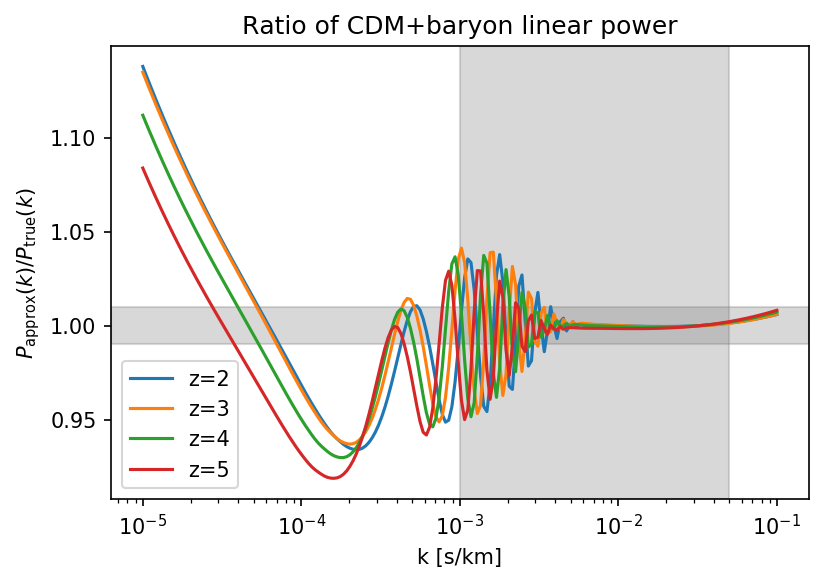

In [9]:
plt.figure()
fix_evol=True
fix_grow=True
for iz in range(Nz): 
    z=zs[iz]
    # interpolate both powers to same k grid
    k=np.logspace(-5,-1,200)
    P_true=np.interp(k,k_kms[iz],P_kms[iz])
    # take into account difference in Hubble parameter
    #H = results.hubble_parameter(z=z)
    H_fid = results_fid.hubble_parameter(z=z)
    # evaluate fiducial power after correcting for differences in Hubble
    x = 1 + (g_star-g_star_fid)*(z-z_star)
    if not fix_evol:
        x = 1
    #print(iz,z,'x',x)
    P_rec = np.interp(x*k,k_kms_fid[iz],P_kms_fid[iz]) * x**3
    # apply change in shape, taking into account evolution of Hubble
    #y = H/(1+z)/H_star*(1+z_star)
    y_fid = H_fid/(1+z)/H_star_fid*(1+z_star)
    y=y_fid*x
    #print(iz,z,'y',y,y_fid,y/y_fid,x)
    P_rec *= np.exp(linP_ratio_kms(np.log(y*k)))
    # correct linear growth
    df = (f_star_fid-f_star)
    if not fix_grow:
        df = 0
    P_rec *= (1+df*(z-z_star)/(1+z_star))**2
    plt.semilogx(k,P_rec/P_true,label='z='+str(z))
plt.title(r"Ratio of CDM+baryon linear power")
plt.xlabel("k [s/km]")
plt.ylabel(r"$P_{\rm approx}(k) / P_{\rm true}(k)$")
plt.legend()
plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
plt.axvspan(0.001,0.05,alpha=0.3, color='gray')